<a href="https://colab.research.google.com/github/REICHIYAN/REI/blob/master/StatArb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

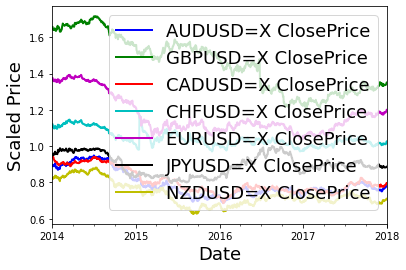

Sell  1000000  @  0.9170860000000001 Position:  -1000000
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Buy  1000000  @  0.913392 Position:  0
OpenPnL:  3610.0000000000023  ClosedPnL:  0  TotalPnL:  3610.0000000000023
Buy  1000000  @  0.911993 Position:  1000000
OpenPnL:  0  ClosedPnL:  3694.0000000001164  TotalPnL:  3694.0000000001164
Sell  1000000  @  0.9117430000000001 Position:  0
OpenPnL:  1048.9999999999666  ClosedPnL:  3694.0000000001164  TotalPnL:  4743.000000000083
Sell  1000000  @  0.900739 Position:  -1000000
OpenPnL:  0  ClosedPnL:  3444.000000000233  TotalPnL:  3444.000000000233
Buy  1000000  @  0.9039959999999999 Position:  0
OpenPnL:  883.9999999999959  ClosedPnL:  3444.000000000233  TotalPnL:  4328.000000000229
Buy  1000000  @  0.912742 Position:  1000000
OpenPnL:  0  ClosedPnL:  187.00000000034925  TotalPnL:  187.00000000034925
Sell  1000000  @  0.903342 Position:  0
OpenPnL:  382.9999999999112  ClosedPnL:  187.00000000034925  TotalPnL:  570.0000000002605
Buy  1000000  @  0.

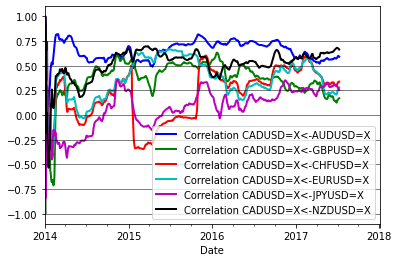

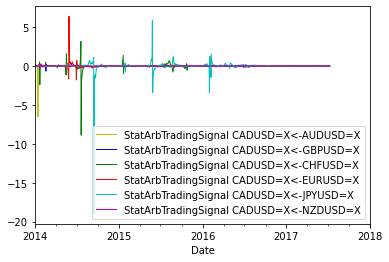

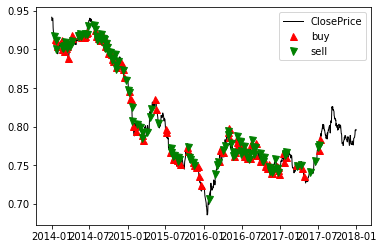

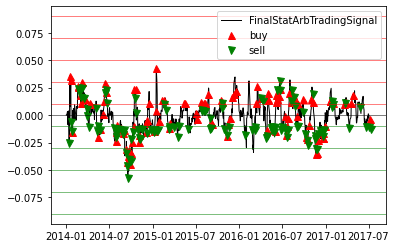

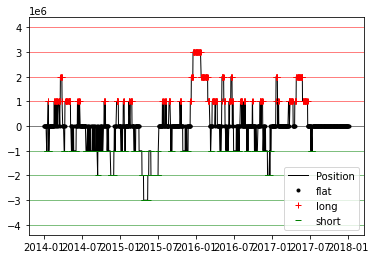

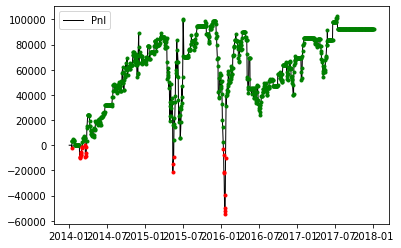

In [3]:
import pandas as pd
from pandas_datareader import data

# Fetch daily data for 4 years, for 7 major currency pairs
TRADING_INSTRUMENT = 'CADUSD=X'
SYMBOLS = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']
START_DATE = '2014-01-01'
END_DATE = '2018-01-01'

# DataSeries for each currency
symbols_data = {}
for symbol in SYMBOLS:
  SRC_DATA_FILENAME = symbol + '_data.pkl'

  try:
    data = pd.read_pickle(SRC_DATA_FILENAME)
  except FileNotFoundError:
    data = data.DataReader(symbol, 'yahoo', START_DATE, END_DATE)
    data.to_pickle(SRC_DATA_FILENAME)

  symbols_data[symbol] = data

# Visualize prices for currency to inspect relationship between them
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

cycol = cycle('bgrcmky')

price_data = pd.DataFrame()
for symbol in SYMBOLS:
  multiplier = 1.0
  if symbol == 'JPYUSD=X':
    multiplier = 100.0

  label = symbol + ' ClosePrice'
  price_data = price_data.assign(label=pd.Series(symbols_data[symbol]['Close'] * multiplier, index=symbols_data[symbol].index))
  ax = price_data['label'].plot(color=next(cycol), lw=2., label=label)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Scaled Price', fontsize=18)
plt.legend(prop={'size': 18})
plt.show()

import statistics as stats

# Constants/variables that are used to compute simple moving average and price deviation from simple moving average
SMA_NUM_PERIODS = 20  # look back period
price_history = {}  # history of prices

PRICE_DEV_NUM_PRICES = 200 # look back period of ClosePrice deviations from SMA
price_deviation_from_sma = {}  # history of ClosePrice deviations from SMA

# We will use this to iterate over all the days of data we have
num_days = len(symbols_data[TRADING_INSTRUMENT].index)
correlation_history = {} # history of correlations per currency pair
delta_projected_actual_history = {} # history of differences between Projected ClosePrice deviation and actual ClosePrice deviation per currency pair

final_delta_projected_history = [] # history of differences between final Projected ClosePrice deviation for TRADING_INSTRUMENT and actual ClosePrice deviation

# Variables for Trading Strategy trade, position & pnl management:
orders = []  # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = []  # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = []  # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0  # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0  # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0  # Current position of the trading strategy
buy_sum_price_qty = 0  # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0  # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0  # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0  # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0  # Open/Unrealized PnL marked to market
closed_pnl = 0  # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
StatArb_VALUE_FOR_BUY_ENTRY = 0.01  # StatArb trading signal value aboe which to enter buy-orders/long-position
StatArb_VALUE_FOR_SELL_ENTRY = -0.01  # StatArb trading signal value below which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 0.01  # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 1000000  # Number of currency to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10  # Minimum Open/Unrealized profit at which to close positions and lock profits

for i in range(0, num_days):
  close_prices = {}

  # Build ClosePrice series, compute SMA for each symbol and price-deviation from SMA for each symbol
  for symbol in SYMBOLS:
    close_prices[symbol] = symbols_data[symbol]['Close'].iloc[i]
    if not symbol in price_history.keys():
      price_history[symbol] = []
      price_deviation_from_sma[symbol] = []

    price_history[symbol].append(close_prices[symbol])
    if len(price_history[symbol]) > SMA_NUM_PERIODS:  # we track at most SMA_NUM_PERIODS number of prices
      del (price_history[symbol][0])

    sma = stats.mean(price_history[symbol]) # Rolling SimpleMovingAverage
    price_deviation_from_sma[symbol].append(close_prices[symbol] - sma) # price deviation from mean
    if len(price_deviation_from_sma[symbol]) > PRICE_DEV_NUM_PRICES:
      del (price_deviation_from_sma[symbol][0])

  # Now compute covariance and correlation between TRADING_INSTRUMENT and every other lead symbol
  # also compute projected price deviation and find delta between projected and actual price deviations.
  projected_dev_from_sma_using = {}
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol
    if correlation_label not in correlation_history.keys(): # first entry for this pair in the history dictionary
      correlation_history[correlation_label] = []
      delta_projected_actual_history[correlation_label] = []

    if len(price_deviation_from_sma[symbol]) < 2: # need atleast two observations to compute covariance/correlation
      correlation_history[correlation_label].append(0)
      delta_projected_actual_history[correlation_label].append(0)
      continue

    corr = np.corrcoef(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    cov = np.cov(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    corr_trading_instrument_lead_instrument = corr[0, 1]  # get the correlation between the 2 series
    cov_trading_instrument_lead_instrument = cov[0, 0] / cov[0, 1] # get the covariance between the 2 series

    correlation_history[correlation_label].append(corr_trading_instrument_lead_instrument)

    # projected-price-deviation-in-TRADING_INSTRUMENT is covariance * price-deviation-in-lead-symbol
    projected_dev_from_sma_using[symbol] = price_deviation_from_sma[symbol][-1] * cov_trading_instrument_lead_instrument

    # delta +ve => signal says TRADING_INSTRUMENT price should have moved up more than what it did
    # delta -ve => signal says TRADING_INSTRUMENT price should have moved down more than what it did.
    delta_projected_actual = (projected_dev_from_sma_using[symbol] - price_deviation_from_sma[TRADING_INSTRUMENT][-1])
    delta_projected_actual_history[correlation_label].append(delta_projected_actual)

  # weigh predictions from each pair, weight is the correlation between those pairs
  sum_weights = 0 # sum of weights is sum of correlations for each symbol with TRADING_INSTRUMENT
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol
    sum_weights += abs(correlation_history[correlation_label][-1])

  final_delta_projected = 0 # will hold final prediction of price deviation in TRADING_INSTRUMENT, weighing projections from all other symbols.
  close_price = close_prices[TRADING_INSTRUMENT]
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol

    # weight projection from a symbol by correlation
    final_delta_projected += (abs(correlation_history[correlation_label][-1]) * delta_projected_actual_history[correlation_label][-1])

  # normalize by diving by sum of weights for all pairs
  if sum_weights != 0:
    final_delta_projected /= sum_weights
  else:
    final_delta_projected = 0

  final_delta_projected_history.append(final_delta_projected)

  # This section checks trading signal against trading parameters/thresholds and positions, to trade.
  #
  # We will perform a sell trade at close_prices if the following conditions are met:
  # 1. The StatArb trading signal value is below Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are long( +ve position ) and current position is profitable enough to lock profit.
  if ((final_delta_projected < StatArb_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)  # StatArb above sell entry threshold, we should sell
      or
      (position > 0 and (open_pnl > MIN_PROFIT_TO_CLOSE))):  # long from -ve StatArb and StatArb has gone positive or position is profitable, sell to close position
    orders.append(-1)  # mark the sell trade
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE  # reduce position by the size of this trade
    sell_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  # update vwap sell-price
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print("Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
    print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))

  # We will perform a buy trade at close_prices if the following conditions are met:
  # 1. The StatArb trading signal value is above Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are short( -ve position ) and current position is profitable enough to lock profit.
  elif ((final_delta_projected > StatArb_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)  # StatArb below buy entry threshold, we should buy
        or
        (position < 0 and (open_pnl > MIN_PROFIT_TO_CLOSE))):  # short from +ve StatArb and StatArb has gone negative or position is profitable, buy to close position
    orders.append(+1)  # mark the buy trade
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE  # increase position by the size of this trade
    buy_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  # update the vwap buy-price
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
    print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))
  else:
    # No trade since none of the conditions were met to buy or sell
    orders.append(0)

  positions.append(position)

  # This section updates Open/Unrealized & Closed/Realized positions
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0:  # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0:  # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty - close_price)
  else:
    # flat, so update closed_pnl and reset tracking variables for positions & pnls
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  pnls.append(closed_pnl + open_pnl)

# Plot correlations between TRADING_INSTRUMENT and other currency pairs
correlation_data = pd.DataFrame()
for symbol in SYMBOLS:
  if symbol == TRADING_INSTRUMENT:
    continue

  correlation_label = TRADING_INSTRUMENT + '<-' + symbol
  correlation_data = correlation_data.assign(label=pd.Series(correlation_history[correlation_label], index=symbols_data[symbol].index))
  ax = correlation_data['label'].plot(color=next(cycol), lw=2., label='Correlation ' + correlation_label)

for i in np.arange(-1, 1, 0.25):
  plt.axhline(y=i, lw=0.5, color='k')
plt.legend()
plt.show()

# Plot StatArb signal provided by each currency pair
delta_projected_actual_data = pd.DataFrame()
for symbol in SYMBOLS:
  if symbol == TRADING_INSTRUMENT:
    continue

  projection_label = TRADING_INSTRUMENT + '<-' + symbol
  delta_projected_actual_data = delta_projected_actual_data.assign(StatArbTradingSignal=pd.Series(delta_projected_actual_history[projection_label], index=symbols_data[TRADING_INSTRUMENT].index))
  ax = delta_projected_actual_data['StatArbTradingSignal'].plot(color=next(cycol), lw=1., label='StatArbTradingSignal ' + projection_label)
plt.legend()
plt.show()

delta_projected_actual_data = delta_projected_actual_data.assign(ClosePrice=pd.Series(symbols_data[TRADING_INSTRUMENT]['Close'], index=symbols_data[TRADING_INSTRUMENT].index))
delta_projected_actual_data = delta_projected_actual_data.assign(FinalStatArbTradingSignal=pd.Series(final_delta_projected_history, index=symbols_data[TRADING_INSTRUMENT].index))
delta_projected_actual_data = delta_projected_actual_data.assign(Trades=pd.Series(orders, index=symbols_data[TRADING_INSTRUMENT].index))
delta_projected_actual_data = delta_projected_actual_data.assign(Position=pd.Series(positions, index=symbols_data[TRADING_INSTRUMENT].index))
delta_projected_actual_data = delta_projected_actual_data.assign(Pnl=pd.Series(pnls, index=symbols_data[TRADING_INSTRUMENT].index))

plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.ClosePrice, color='k', lw=1., label='ClosePrice')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == 1].index, delta_projected_actual_data.ClosePrice[delta_projected_actual_data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == -1].index, delta_projected_actual_data.ClosePrice[delta_projected_actual_data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.FinalStatArbTradingSignal, color='k', lw=1., label='FinalStatArbTradingSignal')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == 1].index, delta_projected_actual_data.FinalStatArbTradingSignal[delta_projected_actual_data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == -1].index, delta_projected_actual_data.FinalStatArbTradingSignal[delta_projected_actual_data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in np.arange(StatArb_VALUE_FOR_BUY_ENTRY, StatArb_VALUE_FOR_BUY_ENTRY * 10, StatArb_VALUE_FOR_BUY_ENTRY * 2):
  plt.axhline(y=i, lw=0.5, color='r')
for i in np.arange(StatArb_VALUE_FOR_SELL_ENTRY, StatArb_VALUE_FOR_SELL_ENTRY * 10, StatArb_VALUE_FOR_SELL_ENTRY * 2):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.Position, color='k', lw=1., label='Position')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Position == 0].index, delta_projected_actual_data.Position[delta_projected_actual_data.Position == 0], color='k', lw=0, marker='.', label='flat')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Position > 0].index, delta_projected_actual_data.Position[delta_projected_actual_data.Position > 0], color='r', lw=0, marker='+', label='long')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Position < 0].index, delta_projected_actual_data.Position[delta_projected_actual_data.Position < 0], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range(NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE * 5, NUM_SHARES_PER_TRADE):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range(-NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE * 5, -NUM_SHARES_PER_TRADE):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.Pnl, color='k', lw=1., label='Pnl')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Pnl > 0].index, delta_projected_actual_data.Pnl[delta_projected_actual_data.Pnl > 0], color='g', lw=0, marker='.')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Pnl < 0].index, delta_projected_actual_data.Pnl[delta_projected_actual_data.Pnl < 0], color='r', lw=0, marker='.')
plt.legend()
plt.show()

delta_projected_actual_data.to_csv("statistical_arbitrage.csv", sep=",")